<div style=" background-color: RGB(0,114,200);" >
<h1 style="margin: auto; padding: 7px 0; color:#fff; text-align: center">PROJET 5</h1>
<h2 style="margin: auto; padding: 15px 0; color:#fff; text-align: center">BottleNeck - Optimiser la gestion des données d'une boutique
</h2>
</div>

In [56]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import xlrd

In [57]:
erp = pd.read_excel("../Source/Fichier_erp.xlsx")
liaison = pd.read_excel("../Source/fichier_liaison.xlsx")
web = pd.read_excel("../Source/Fichier_web.xlsx")

/Users/ishemzerzour/Desktop/My Program Files/Projet_4-BottleNeck/venv/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/ishemzerzour/Desktop/My Program Files/Projet_4-BottleNeck/venv/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/ishemzerzour/Desktop/My Program Files/Projet_4-BottleNeck/venv/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


<div style="background-color: RGB(0,150,250);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 1 - Exploration du fichier ERP (Référence produit)</h2>
</div>

In [3]:
erp

,product_id,onsale_web,price,stock_quantity,stock_status
0,3847,1,24.2,0,outofstock
1,3849,1,34.3,0,outofstock
2,3850,1,20.8,0,outofstock
3,4032,1,14.1,0,outofstock
4,4039,1,46.0,0,outofstock
...,...,...,...,...,...
820,7203,0,45.0,30,instock
821,7204,0,45.0,9,instock
822,7247,1,54.8,23,instock
823,7329,0,26.5,14,instock


In [4]:
erp = erp.drop_duplicates()

In [5]:
#changer le type de la colonne product_id
erp["product_id"] = erp["product_id"].astype(object)

In [6]:
erp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      825 non-null    object 
 1   onsale_web      825 non-null    int64  
 2   price           825 non-null    float64
 3   stock_quantity  825 non-null    int64  
 4   stock_status    825 non-null    object 
dtypes: float64(1), int64(2), object(2)
memory usage: 32.4+ KB


In [7]:
#product_id = Unique ? OUI 
print(erp['product_id'].nunique())
print('Les id produits sont uniques')
#stock_status = Quantité de stock / Boolean
print(erp['stock_status'].nunique())
print('Les stocks sont épuisés ou non')
#onsale_web = Produits mis en ligne ou non / Boolean
print(erp['onsale_web'].nunique())
print('Produit mis en ligne ou non')


825
Les id produits sont uniques
2
Les stocks sont épuisés ou non
2
Produit mis en ligne ou non


In [8]:
erp.describe()

,onsale_web,price,stock_quantity
count,825.000000,825.000000,825.000000
mean,0.869091,32.384000,26.583030
std,0.337506,26.832271,45.875948
min,0.000000,-8.000000,-1.000000
25%,1.000000,14.600000,1.000000
50%,1.000000,24.400000,11.000000
75%,1.000000,42.000000,34.000000
max,1.000000,225.000000,578.000000


In [9]:
#Il y a des prix négatifs : assigner les valeurs absolu (positif) ? 
erp.loc[erp['price'] <= 0]

,product_id,onsale_web,price,stock_quantity,stock_status
469,5017,0,-8.0,0,outofstock
739,6594,0,-1.0,192,instock


'Les produits référencé qui ont un prix négatif ne sont pas vendus en ligne'


In [10]:
#changement des prix négatif en valeurs positives : OK
erp['price'] = erp['price'].abs()

In [11]:
#vérification du changement en valeurs positives : OK 
erp.loc[(erp['product_id'] == 5017) | (erp['product_id'] == 6594)]

,product_id,onsale_web,price,stock_quantity,stock_status
469,5017,0,8.0,0,outofstock
739,6594,0,1.0,192,instock


In [12]:
#Il y a des stock_quantity négatifs ? Remplacer par 0 : OK 
erp.loc[erp['stock_quantity'] < 0]

,product_id,onsale_web,price,stock_quantity,stock_status
449,4973,0,10.0,-1,outofstock
573,5700,1,44.5,-1,outofstock


In [13]:
#quand un stock est négatif, remplacer par 0 : OK
erp.loc[erp['stock_quantity'] < 0, 'stock_quantity'] = 0

In [14]:
#vérification : OK
erp.loc[(erp['product_id'] == 4973) | (erp['product_id'] == 5700)]

,product_id,onsale_web,price,stock_quantity,stock_status
449,4973,0,10.0,0,outofstock
573,5700,1,44.5,0,outofstock


In [15]:
#Query qui donne les ligne ou le stock est positif et un statut "outofstock"
erp.query("stock_status == 'outofstock' and stock_quantity > 0")

,product_id,onsale_web,price,stock_quantity,stock_status
19,4055,0,86.1,1,outofstock
49,4090,0,73.0,6,outofstock
50,4092,0,47.0,6,outofstock
630,5826,1,41.2,12,outofstock
696,6125,0,14.2,48,outofstock


In [16]:
# Remplacer les valeurs de stock_status par 'instock' lorsque stock_quantity est supérieur à 0
erp.loc[erp['stock_quantity'] > 0, 'stock_status'] = 'instock'

In [17]:
#idem avec les stock = 0 et un statut "instock"
erp.query("stock_status == 'instock' and stock_quantity == 0")

,product_id,onsale_web,price,stock_quantity,stock_status
443,4954,1,25.0,0,instock


In [18]:
# Remplacer les valeurs de stock_status par 'outofstock' lorsque stock_quantity est égal à 0
erp.loc[erp['stock_quantity'] == 0, 'stock_status'] = 'outofstock'

In [19]:
erp = erp.loc[erp['onsale_web'] == 1]
erp.reset_index(drop=True, inplace=True)
erp

,product_id,onsale_web,price,stock_quantity,stock_status
0,3847,1,24.2,0,outofstock
1,3849,1,34.3,0,outofstock
2,3850,1,20.8,0,outofstock
3,4032,1,14.1,0,outofstock
4,4039,1,46.0,0,outofstock
...,...,...,...,...,...
712,6930,1,8.4,83,instock
713,7023,1,27.5,15,instock
714,7025,1,69.0,2,instock
715,7247,1,54.8,23,instock


<div style="background-color: RGB(0,150,250);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 2 - Exploration du fichier Web (Produits commercialisés en ligne)</h2>
</div>

In [20]:
web

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,16004,0,0,0,0.0,5.0,NaN,NaN,2.0,2018-06-07 16:27:25,...,chateau-du-couvent-pomerol-2017,2020-08-25 18:35:02,2020-08-25 16:35:02,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
1,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaT,...,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,15075,0,0,0,0.0,3.0,taxable,NaN,2.0,2018-02-14 15:39:43,...,pares-balta-penedes-indigena-2017,2020-08-20 15:35:02,2020-08-20 13:35:02,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
3,16209,0,0,0,0.0,6.0,taxable,NaN,2.0,2018-02-14 17:15:31,...,maurel-cabardes-tradition-2017,2020-08-05 18:05:03,2020-08-05 16:05:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
4,15763,0,0,0,0.0,1.0,NaN,NaN,2.0,2020-01-25 14:08:16,...,domaine-de-la-monardiere-vacqueyras-les-vieill...,2020-08-21 11:35:02,2020-08-21 09:35:02,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1508,12881,0,0,0,0.0,2.0,NaN,NaN,2.0,2019-03-28 15:25:14,...,montbourgeau-etoile-vin-jaune-2009,2019-12-30 10:30:01,2019-12-30 09:30:01,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0
1509,15663,0,0,0,0.0,3.0,taxable,NaN,2.0,2018-02-27 10:27:01,...,chermette-domaine-du-vissoux-brouilly-pierreux...,2020-08-01 09:35:02,2020-08-01 07:35:02,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1510,15910,0,0,0,0.0,0.0,taxable,NaN,2.0,2019-03-28 10:59:43,...,thevenet-quintaine-vire-clesse-la-bongran-2015,2020-08-14 10:45:02,2020-08-14 08:45:02,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1511,38,0,0,0,0.0,38.0,NaN,NaN,2.0,2018-04-18 12:25:58,...,emile-boeckel-cremant-brut-blanc-de-blancs,2020-08-27 17:15:03,2020-08-27 15:15:03,NaN,0.0,https://www.bottle-neck.fr/wp-content/uploads/...,0.0,attachment,image/jpeg,0.0


In [21]:
#Boucle afin de régler le problème d'encodage

def clean_html_tags(text):
    if pd.isna(text):
        return text
    else:
        soup = BeautifulSoup(text, "html.parser")
        return soup.get_text()

In [22]:
web["post_excerpt"] = web["post_excerpt"].apply(clean_html_tags)

/var/folders/rg/h0w5cjr90257kx52nm8zrv280000gn/T/ipykernel_48667/1729825940.py:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [23]:
web = web.drop_duplicates()

In [24]:
#supprimer les lignes totalement vide 'sku' et reinitialiser les index
web = web.dropna(subset=['sku'], how='all').reset_index(drop=True)

In [25]:
#supprimer les colonnes totalement inutiles:
drop_column = ['tax_class', 'post_content', 'post_password', 'post_content_filtered','post_status','comment_status','ping_status','post_parent','menu_order','post_mime_type','comment_count','virtual','downloadable','rating_count','average_rating','tax_status']
web = web.drop(columns=drop_column)
web.reset_index(drop=True)
web

,sku,total_sales,post_author,post_date,post_date_gmt,post_title,post_excerpt,post_name,post_modified,post_modified_gmt,guid,post_type
0,16004,5.0,2.0,2018-06-07 16:27:25,2018-06-07 14:27:25,Château du Couvent Pomerol 2017,NaN,chateau-du-couvent-pomerol-2017,2020-08-25 18:35:02,2020-08-25 16:35:02,https://www.bottle-neck.fr/wp-content/uploads/...,attachment
1,15075,3.0,2.0,2018-02-14 15:39:43,2018-02-14 14:39:43,Parés Baltà Penedès Indigena 2017,Des couleurs et aromes intenses où le fruit et...,pares-balta-penedes-indigena-2017,2020-08-20 15:35:02,2020-08-20 13:35:02,https://www.bottle-neck.fr/?post_type=product&...,product
2,16209,6.0,2.0,2018-02-14 17:15:31,2018-02-14 16:15:31,Maurel Cabardès Tradition 2017,"Un joli nez aux arômes de fruits rouges, de ca...",maurel-cabardes-tradition-2017,2020-08-05 18:05:03,2020-08-05 16:05:03,https://www.bottle-neck.fr/?post_type=product&...,product
3,15763,1.0,2.0,2020-01-25 14:08:16,2020-01-25 13:08:16,Domaine de la Monardière Vacqueyras Vieilles V...,NaN,domaine-de-la-monardiere-vacqueyras-les-vieill...,2020-08-21 11:35:02,2020-08-21 09:35:02,https://www.bottle-neck.fr/wp-content/uploads/...,attachment
4,13895,0.0,2.0,2019-03-19 10:41:50,2019-03-19 09:41:50,Château Saransot-Dupré Bordeaux Blanc 2016,Rareté en Médoc (mais d’A.O.C. Bordeaux) le do...,chateau-saransot-dupre-bordeaux-blanc-2016,2020-04-25 21:11:40,2020-04-25 19:11:40,https://www.bottle-neck.fr/?post_type=product&...,product
...,...,...,...,...,...,...,...,...,...,...,...,...
1423,12881,2.0,2.0,2019-03-28 15:25:14,2019-03-28 14:25:14,Domaine de Montbourgeau L'Etoile Vin Jaune 2009,NaN,montbourgeau-etoile-vin-jaune-2009,2019-12-30 10:30:01,2019-12-30 09:30:01,https://www.bottle-neck.fr/wp-content/uploads/...,attachment
1424,15663,3.0,2.0,2018-02-27 10:27:01,2018-02-27 09:27:01,Chermette Domaine du Vissoux Brouilly Pierreux...,Le Brouilly est le plus méridional des crus du...,chermette-domaine-du-vissoux-brouilly-pierreux...,2020-08-01 09:35:02,2020-08-01 07:35:02,https://www.bottle-neck.fr/?post_type=product&...,product
1425,15910,0.0,2.0,2019-03-28 10:59:43,2019-03-28 09:59:43,Thevenet Quintaine Viré-Clessé La Bongran 2015,C’est dans cette cuvée la pleine expression du...,thevenet-quintaine-vire-clesse-la-bongran-2015,2020-08-14 10:45:02,2020-08-14 08:45:02,https://www.bottle-neck.fr/?post_type=product&...,product
1426,38,38.0,2.0,2018-04-18 12:25:58,2018-04-18 10:25:58,Emile Boeckel Crémant Brut Blanc de Blancs,NaN,emile-boeckel-cremant-brut-blanc-de-blancs,2020-08-27 17:15:03,2020-08-27 15:15:03,https://www.bottle-neck.fr/wp-content/uploads/...,attachment


In [26]:
#on enléve le bon cadeau de 25€ et on ne garde que les ligne 'post_type' = 'product'
web.drop(web[web['sku'] == 'bon-cadeau-25-euros'].index, inplace=True)
web = web.loc[web['post_type'] == 'product'].reset_index(drop=True)
web



,sku,total_sales,post_author,post_date,post_date_gmt,post_title,post_excerpt,post_name,post_modified,post_modified_gmt,guid,post_type
0,15075,3.0,2.0,2018-02-14 15:39:43,2018-02-14 14:39:43,Parés Baltà Penedès Indigena 2017,Des couleurs et aromes intenses où le fruit et...,pares-balta-penedes-indigena-2017,2020-08-20 15:35:02,2020-08-20 13:35:02,https://www.bottle-neck.fr/?post_type=product&...,product
1,16209,6.0,2.0,2018-02-14 17:15:31,2018-02-14 16:15:31,Maurel Cabardès Tradition 2017,"Un joli nez aux arômes de fruits rouges, de ca...",maurel-cabardes-tradition-2017,2020-08-05 18:05:03,2020-08-05 16:05:03,https://www.bottle-neck.fr/?post_type=product&...,product
2,13895,0.0,2.0,2019-03-19 10:41:50,2019-03-19 09:41:50,Château Saransot-Dupré Bordeaux Blanc 2016,Rareté en Médoc (mais d’A.O.C. Bordeaux) le do...,chateau-saransot-dupre-bordeaux-blanc-2016,2020-04-25 21:11:40,2020-04-25 19:11:40,https://www.bottle-neck.fr/?post_type=product&...,product
3,12857,0.0,2.0,2018-04-12 17:56:13,2018-04-12 15:56:13,Château de Meursault Puligny-Montrachet 1er Cr...,Il présente une grande fraîcheur minérale au n...,chateau-de-puligny-montrachet-1cru-champ-canet...,2020-02-06 16:35:02,2020-02-06 15:35:02,https://www.bottle-neck.fr/?post_type=product&...,product
4,14106,0.0,2.0,2019-06-08 09:54:21,2019-06-08 07:54:21,Stéphane Tissot Château-Chalon 2011,Ce vin peut-être dégusté sur sa jeunesse mais ...,stephane-tissot-chateau-chalon-2011,2020-05-29 17:35:03,2020-05-29 15:35:03,https://www.bottle-neck.fr/?post_type=product&...,product
...,...,...,...,...,...,...,...,...,...,...,...,...
708,15941,4.0,2.0,2018-02-12 14:26:52,2018-02-12 13:26:52,Domaine de la Jérôme Côtes du Rhône Village 201,"Un vin opulent, à la texture onctueuse, et tou...",jerome-cotes-du-rhone-2018,2020-06-25 14:00:03,2020-06-25 12:00:03,https://www.bottle-neck.fr/?post_type=product&...,product
709,10459,0.0,2.0,2018-04-13 15:58:19,2018-04-13 13:58:19,Alphonse Mellot Sancerre Rouge Génération XIX ...,"Robe d'un superbe rubis, dense et profond - As...",alphonse-mellot-sancerre-rouge-generation-xix-...,2020-08-24 14:05:02,2020-08-24 12:05:02,https://www.bottle-neck.fr/?post_type=product&...,product
710,16320,3.0,2.0,2018-02-12 12:49:29,2018-02-12 11:49:29,Mourgues du Grès IGP Pont du Gard Terre d'Arge...,"Magnifique exemple d’assemblage réussi, ou cha...",mourgues-du-gres-costieres-de-nimes-terre-darg...,2020-08-25 11:15:03,2020-08-25 09:15:03,https://www.bottle-neck.fr/?post_type=product&...,product
711,15663,3.0,2.0,2018-02-27 10:27:01,2018-02-27 09:27:01,Chermette Domaine du Vissoux Brouilly Pierreux...,Le Brouilly est le plus méridional des crus du...,chermette-domaine-du-vissoux-brouilly-pierreux...,2020-08-01 09:35:02,2020-08-01 07:35:02,https://www.bottle-neck.fr/?post_type=product&...,product


<div style="background-color: RGB(0,150,250);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 3 - Exploration du fichier Liaison</h2>
</div>

In [27]:
liaison

,product_id,id_web
0,3847,15298
1,3849,15296
2,3850,15300
3,4032,19814
4,4039,19815
...,...,...
820,7203,NaN
821,7204,NaN
822,7247,13127-1
823,7329,14680-1


In [28]:
liaison = liaison.drop_duplicates()

In [29]:
#changer le type integer de la colonne product_id en string
liaison["product_id"] = liaison["product_id"].astype(object)


In [30]:
#Renommer la colonne id_web en sku
liaison = liaison.rename(columns={'id_web': 'sku'})
liaison.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  825 non-null    object
 1   sku         734 non-null    object
dtypes: object(2)
memory usage: 13.0+ KB


In [31]:
#on va verifier si les product id sont unique
print(liaison['product_id'].nunique())
print("les product_id sont bien uniques")
#on va verifier si les sku sont unique
print(liaison['sku'].nunique())
print("les sku ne sont pas uniques")

825
les product_id sont bien uniques
734
les sku ne sont pas uniques


In [32]:
liaison.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  825 non-null    object
 1   sku         734 non-null    object
dtypes: object(2)
memory usage: 13.0+ KB


<div style="background-color: RGB(0,150,250);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 4 - Analyse du fichier WEB avec Liaison</h2>
</div>

In [33]:
web_liaison = pd.merge(web, liaison, how="left", on="sku")
web_liaison

,sku,total_sales,post_author,post_date,post_date_gmt,post_title,post_excerpt,post_name,post_modified,post_modified_gmt,guid,post_type,product_id
0,15075,3.0,2.0,2018-02-14 15:39:43,2018-02-14 14:39:43,Parés Baltà Penedès Indigena 2017,Des couleurs et aromes intenses où le fruit et...,pares-balta-penedes-indigena-2017,2020-08-20 15:35:02,2020-08-20 13:35:02,https://www.bottle-neck.fr/?post_type=product&...,product,4165
1,16209,6.0,2.0,2018-02-14 17:15:31,2018-02-14 16:15:31,Maurel Cabardès Tradition 2017,"Un joli nez aux arômes de fruits rouges, de ca...",maurel-cabardes-tradition-2017,2020-08-05 18:05:03,2020-08-05 16:05:03,https://www.bottle-neck.fr/?post_type=product&...,product,4174
2,13895,0.0,2.0,2019-03-19 10:41:50,2019-03-19 09:41:50,Château Saransot-Dupré Bordeaux Blanc 2016,Rareté en Médoc (mais d’A.O.C. Bordeaux) le do...,chateau-saransot-dupre-bordeaux-blanc-2016,2020-04-25 21:11:40,2020-04-25 19:11:40,https://www.bottle-neck.fr/?post_type=product&...,product,5796
3,12857,0.0,2.0,2018-04-12 17:56:13,2018-04-12 15:56:13,Château de Meursault Puligny-Montrachet 1er Cr...,Il présente une grande fraîcheur minérale au n...,chateau-de-puligny-montrachet-1cru-champ-canet...,2020-02-06 16:35:02,2020-02-06 15:35:02,https://www.bottle-neck.fr/?post_type=product&...,product,4582
4,14106,0.0,2.0,2019-06-08 09:54:21,2019-06-08 07:54:21,Stéphane Tissot Château-Chalon 2011,Ce vin peut-être dégusté sur sa jeunesse mais ...,stephane-tissot-chateau-chalon-2011,2020-05-29 17:35:03,2020-05-29 15:35:03,https://www.bottle-neck.fr/?post_type=product&...,product,6106
...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,15941,4.0,2.0,2018-02-12 14:26:52,2018-02-12 13:26:52,Domaine de la Jérôme Côtes du Rhône Village 201,"Un vin opulent, à la texture onctueuse, et tou...",jerome-cotes-du-rhone-2018,2020-06-25 14:00:03,2020-06-25 12:00:03,https://www.bottle-neck.fr/?post_type=product&...,product,4074
709,10459,0.0,2.0,2018-04-13 15:58:19,2018-04-13 13:58:19,Alphonse Mellot Sancerre Rouge Génération XIX ...,"Robe d'un superbe rubis, dense et profond - As...",alphonse-mellot-sancerre-rouge-generation-xix-...,2020-08-24 14:05:02,2020-08-24 12:05:02,https://www.bottle-neck.fr/?post_type=product&...,product,4617
710,16320,3.0,2.0,2018-02-12 12:49:29,2018-02-12 11:49:29,Mourgues du Grès IGP Pont du Gard Terre d'Arge...,"Magnifique exemple d’assemblage réussi, ou cha...",mourgues-du-gres-costieres-de-nimes-terre-darg...,2020-08-25 11:15:03,2020-08-25 09:15:03,https://www.bottle-neck.fr/?post_type=product&...,product,4062
711,15663,3.0,2.0,2018-02-27 10:27:01,2018-02-27 09:27:01,Chermette Domaine du Vissoux Brouilly Pierreux...,Le Brouilly est le plus méridional des crus du...,chermette-domaine-du-vissoux-brouilly-pierreux...,2020-08-01 09:35:02,2020-08-01 07:35:02,https://www.bottle-neck.fr/?post_type=product&...,product,4262


In [34]:
#On regarde les ligne ou il manque un sku : 3 référence web ne sont pas renseignés
web_liaison.loc[web_liaison['sku'].isnull()]

,sku,total_sales,post_author,post_date,post_date_gmt,post_title,post_excerpt,post_name,post_modified,post_modified_gmt,guid,post_type,product_id


In [35]:
web_liaison = web_liaison.dropna(subset=['sku']).reset_index(drop=True)

In [36]:
#1.3 J'affiche les ligne qui ont un sku null (la ce serai un problème)
web_liaison.info()
web_liaison


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   sku                713 non-null    object        
 1   total_sales        713 non-null    float64       
 2   post_author        713 non-null    float64       
 3   post_date          713 non-null    datetime64[ns]
 4   post_date_gmt      713 non-null    datetime64[ns]
 5   post_title         713 non-null    object        
 6   post_excerpt       713 non-null    object        
 7   post_name          713 non-null    object        
 8   post_modified      713 non-null    datetime64[ns]
 9   post_modified_gmt  713 non-null    datetime64[ns]
 10  guid               713 non-null    object        
 11  post_type          713 non-null    object        
 12  product_id         713 non-null    object        
dtypes: datetime64[ns](4), float64(2), object(7)
memory usage: 72.5+ K

,sku,total_sales,post_author,post_date,post_date_gmt,post_title,post_excerpt,post_name,post_modified,post_modified_gmt,guid,post_type,product_id
0,15075,3.0,2.0,2018-02-14 15:39:43,2018-02-14 14:39:43,Parés Baltà Penedès Indigena 2017,Des couleurs et aromes intenses où le fruit et...,pares-balta-penedes-indigena-2017,2020-08-20 15:35:02,2020-08-20 13:35:02,https://www.bottle-neck.fr/?post_type=product&...,product,4165
1,16209,6.0,2.0,2018-02-14 17:15:31,2018-02-14 16:15:31,Maurel Cabardès Tradition 2017,"Un joli nez aux arômes de fruits rouges, de ca...",maurel-cabardes-tradition-2017,2020-08-05 18:05:03,2020-08-05 16:05:03,https://www.bottle-neck.fr/?post_type=product&...,product,4174
2,13895,0.0,2.0,2019-03-19 10:41:50,2019-03-19 09:41:50,Château Saransot-Dupré Bordeaux Blanc 2016,Rareté en Médoc (mais d’A.O.C. Bordeaux) le do...,chateau-saransot-dupre-bordeaux-blanc-2016,2020-04-25 21:11:40,2020-04-25 19:11:40,https://www.bottle-neck.fr/?post_type=product&...,product,5796
3,12857,0.0,2.0,2018-04-12 17:56:13,2018-04-12 15:56:13,Château de Meursault Puligny-Montrachet 1er Cr...,Il présente une grande fraîcheur minérale au n...,chateau-de-puligny-montrachet-1cru-champ-canet...,2020-02-06 16:35:02,2020-02-06 15:35:02,https://www.bottle-neck.fr/?post_type=product&...,product,4582
4,14106,0.0,2.0,2019-06-08 09:54:21,2019-06-08 07:54:21,Stéphane Tissot Château-Chalon 2011,Ce vin peut-être dégusté sur sa jeunesse mais ...,stephane-tissot-chateau-chalon-2011,2020-05-29 17:35:03,2020-05-29 15:35:03,https://www.bottle-neck.fr/?post_type=product&...,product,6106
...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,15941,4.0,2.0,2018-02-12 14:26:52,2018-02-12 13:26:52,Domaine de la Jérôme Côtes du Rhône Village 201,"Un vin opulent, à la texture onctueuse, et tou...",jerome-cotes-du-rhone-2018,2020-06-25 14:00:03,2020-06-25 12:00:03,https://www.bottle-neck.fr/?post_type=product&...,product,4074
709,10459,0.0,2.0,2018-04-13 15:58:19,2018-04-13 13:58:19,Alphonse Mellot Sancerre Rouge Génération XIX ...,"Robe d'un superbe rubis, dense et profond - As...",alphonse-mellot-sancerre-rouge-generation-xix-...,2020-08-24 14:05:02,2020-08-24 12:05:02,https://www.bottle-neck.fr/?post_type=product&...,product,4617
710,16320,3.0,2.0,2018-02-12 12:49:29,2018-02-12 11:49:29,Mourgues du Grès IGP Pont du Gard Terre d'Arge...,"Magnifique exemple d’assemblage réussi, ou cha...",mourgues-du-gres-costieres-de-nimes-terre-darg...,2020-08-25 11:15:03,2020-08-25 09:15:03,https://www.bottle-neck.fr/?post_type=product&...,product,4062
711,15663,3.0,2.0,2018-02-27 10:27:01,2018-02-27 09:27:01,Chermette Domaine du Vissoux Brouilly Pierreux...,Le Brouilly est le plus méridional des crus du...,chermette-domaine-du-vissoux-brouilly-pierreux...,2020-08-01 09:35:02,2020-08-01 07:35:02,https://www.bottle-neck.fr/?post_type=product&...,product,4262


<div style="background-color: RGB(0,150,250);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 5 - Analyse du fichier ERP avec web_Liaison</h2>
</div>

In [37]:
#1 : Je merge ERP et web_liaison
erp_web_liaison = pd.merge(erp, web_liaison, how="right", on="product_id")
erp_web_liaison

,product_id,onsale_web,price,stock_quantity,stock_status,sku,total_sales,post_author,post_date,post_date_gmt,post_title,post_excerpt,post_name,post_modified,post_modified_gmt,guid,post_type
0,4165,1,12.0,57,instock,15075,3.0,2.0,2018-02-14 15:39:43,2018-02-14 14:39:43,Parés Baltà Penedès Indigena 2017,Des couleurs et aromes intenses où le fruit et...,pares-balta-penedes-indigena-2017,2020-08-20 15:35:02,2020-08-20 13:35:02,https://www.bottle-neck.fr/?post_type=product&...,product
1,4174,1,5.7,94,instock,16209,6.0,2.0,2018-02-14 17:15:31,2018-02-14 16:15:31,Maurel Cabardès Tradition 2017,"Un joli nez aux arômes de fruits rouges, de ca...",maurel-cabardes-tradition-2017,2020-08-05 18:05:03,2020-08-05 16:05:03,https://www.bottle-neck.fr/?post_type=product&...,product
2,5796,1,12.5,12,instock,13895,0.0,2.0,2019-03-19 10:41:50,2019-03-19 09:41:50,Château Saransot-Dupré Bordeaux Blanc 2016,Rareté en Médoc (mais d’A.O.C. Bordeaux) le do...,chateau-saransot-dupre-bordeaux-blanc-2016,2020-04-25 21:11:40,2020-04-25 19:11:40,https://www.bottle-neck.fr/?post_type=product&...,product
3,4582,1,109.6,7,instock,12857,0.0,2.0,2018-04-12 17:56:13,2018-04-12 15:56:13,Château de Meursault Puligny-Montrachet 1er Cr...,Il présente une grande fraîcheur minérale au n...,chateau-de-puligny-montrachet-1cru-champ-canet...,2020-02-06 16:35:02,2020-02-06 15:35:02,https://www.bottle-neck.fr/?post_type=product&...,product
4,6106,1,74.8,15,instock,14106,0.0,2.0,2019-06-08 09:54:21,2019-06-08 07:54:21,Stéphane Tissot Château-Chalon 2011,Ce vin peut-être dégusté sur sa jeunesse mais ...,stephane-tissot-chateau-chalon-2011,2020-05-29 17:35:03,2020-05-29 15:35:03,https://www.bottle-neck.fr/?post_type=product&...,product
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,4074,1,12.7,50,instock,15941,4.0,2.0,2018-02-12 14:26:52,2018-02-12 13:26:52,Domaine de la Jérôme Côtes du Rhône Village 201,"Un vin opulent, à la texture onctueuse, et tou...",jerome-cotes-du-rhone-2018,2020-06-25 14:00:03,2020-06-25 12:00:03,https://www.bottle-neck.fr/?post_type=product&...,product
709,4617,1,67.5,1,instock,10459,0.0,2.0,2018-04-13 15:58:19,2018-04-13 13:58:19,Alphonse Mellot Sancerre Rouge Génération XIX ...,"Robe d'un superbe rubis, dense et profond - As...",alphonse-mellot-sancerre-rouge-generation-xix-...,2020-08-24 14:05:02,2020-08-24 12:05:02,https://www.bottle-neck.fr/?post_type=product&...,product
710,4062,1,11.9,60,instock,16320,3.0,2.0,2018-02-12 12:49:29,2018-02-12 11:49:29,Mourgues du Grès IGP Pont du Gard Terre d'Arge...,"Magnifique exemple d’assemblage réussi, ou cha...",mourgues-du-gres-costieres-de-nimes-terre-darg...,2020-08-25 11:15:03,2020-08-25 09:15:03,https://www.bottle-neck.fr/?post_type=product&...,product
711,4262,1,15.8,35,instock,15663,3.0,2.0,2018-02-27 10:27:01,2018-02-27 09:27:01,Chermette Domaine du Vissoux Brouilly Pierreux...,Le Brouilly est le plus méridional des crus du...,chermette-domaine-du-vissoux-brouilly-pierreux...,2020-08-01 09:35:02,2020-08-01 07:35:02,https://www.bottle-neck.fr/?post_type=product&...,product


<div style="background-color: RGB(0,150,250);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 6 - Calcul des CA produits et totaux</h2>
</div>

In [38]:
# Creation d'une colonne contenant le chiffre d'affaire par produits + CA total en ligne:
erp_web_liaison["ca_produit"] = erp_web_liaison["price"]*erp_web_liaison["total_sales"]
erp_web_liaison = erp_web_liaison.round({'ca_produit': 2})
erp_web_liaison.head()

,product_id,onsale_web,price,stock_quantity,stock_status,sku,total_sales,post_author,post_date,post_date_gmt,post_title,post_excerpt,post_name,post_modified,post_modified_gmt,guid,post_type,ca_produit
0,4165,1,12.0,57,instock,15075,3.0,2.0,2018-02-14 15:39:43,2018-02-14 14:39:43,Parés Baltà Penedès Indigena 2017,Des couleurs et aromes intenses où le fruit et...,pares-balta-penedes-indigena-2017,2020-08-20 15:35:02,2020-08-20 13:35:02,https://www.bottle-neck.fr/?post_type=product&...,product,36.0
1,4174,1,5.7,94,instock,16209,6.0,2.0,2018-02-14 17:15:31,2018-02-14 16:15:31,Maurel Cabardès Tradition 2017,"Un joli nez aux arômes de fruits rouges, de ca...",maurel-cabardes-tradition-2017,2020-08-05 18:05:03,2020-08-05 16:05:03,https://www.bottle-neck.fr/?post_type=product&...,product,34.2
2,5796,1,12.5,12,instock,13895,0.0,2.0,2019-03-19 10:41:50,2019-03-19 09:41:50,Château Saransot-Dupré Bordeaux Blanc 2016,Rareté en Médoc (mais d’A.O.C. Bordeaux) le do...,chateau-saransot-dupre-bordeaux-blanc-2016,2020-04-25 21:11:40,2020-04-25 19:11:40,https://www.bottle-neck.fr/?post_type=product&...,product,0.0
3,4582,1,109.6,7,instock,12857,0.0,2.0,2018-04-12 17:56:13,2018-04-12 15:56:13,Château de Meursault Puligny-Montrachet 1er Cr...,Il présente une grande fraîcheur minérale au n...,chateau-de-puligny-montrachet-1cru-champ-canet...,2020-02-06 16:35:02,2020-02-06 15:35:02,https://www.bottle-neck.fr/?post_type=product&...,product,0.0
4,6106,1,74.8,15,instock,14106,0.0,2.0,2019-06-08 09:54:21,2019-06-08 07:54:21,Stéphane Tissot Château-Chalon 2011,Ce vin peut-être dégusté sur sa jeunesse mais ...,stephane-tissot-chateau-chalon-2011,2020-05-29 17:35:03,2020-05-29 15:35:03,https://www.bottle-neck.fr/?post_type=product&...,product,0.0


In [39]:
Ca_Tot = sum(erp_web_liaison["ca_produit"])
print("Le chiffre d'affaire total est de", Ca_Tot, "€")

Le chiffre d'affaire total est de 70318.6 €


In [40]:
#On supprime les colonnes inutiles
erp_web_liaison = erp_web_liaison.drop(columns=['post_date_gmt','post_excerpt','post_name','post_modified','post_modified_gmt','guid','post_type','post_author'])

<div style="background-color: RGB(0,150,250);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 7 - Analyse des prix et représentation graphique: (outliers)</h2>
</div>

In [41]:
erp_web_liaison[["price"]].describe()


,price
count,713.000000
mean,32.503647
std,27.828629
min,5.200000
25%,14.100000
50%,23.500000
75%,42.200000
max,225.000000


**La méthode .describe nous donne un résumé statistique basique de la colonne price de notre dataframe.**
* Nous avons donc 713 valeurs avec 5,20€ pour le prix minimum et 225€ pour le prix maximum.
* Nous avons aussi les premier et troisème percentiles ainsi que la médiane (second percentil, 50%) à 23,50€.
* l'écart type est de 27,82€
* La moyenne de 32,50€. On note qu'elle est différente de la médiane.


/Users/ishemzerzour/Desktop/My Program Files/Projet_4-BottleNeck/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Répartition des prix')

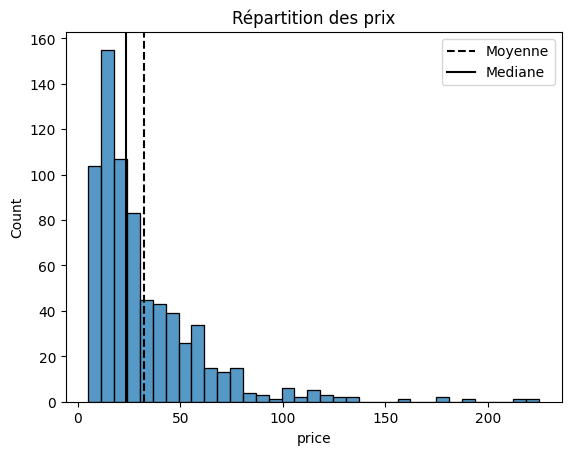

In [42]:
moyenne = erp_web_liaison["price"].mean()
mediane = erp_web_liaison["price"].median()

#Representation de la repartition des prix en histogramme:
sns.histplot(data=erp_web_liaison["price"])
plt.axvline(moyenne, color="black", linestyle="--")
plt.axvline(mediane, color="black", linestyle="-")
plt.legend({"Moyenne":moyenne,"Mediane":mediane})
plt.title("Répartition des prix")

**On peut voir la moyenne et la médiane. La médiane est décalée sur la gauche de notre graphique, les premiers prix sont donc plus fréquents dans notre boutique que les plus élevé. Visuellement et sans avoir encore de confirmation tangible il semblerait que les outliers se retrouvent plutôt parmi les prix élevés.**

In [43]:
# Calcul des quartiles
Q1 = erp_web_liaison['price'].quantile(0.25)
Q3 = erp_web_liaison['price'].quantile(0.75)

# Calcul de l'IQR (écart inter quartile)
IQR = Q3 - Q1

# Identification des outliers
outliers_iqr = erp_web_liaison[(erp_web_liaison['price'] < Q1 - 1.5 * IQR) | (erp_web_liaison['price'] > Q3 + 1.5 * IQR)]


In [44]:
# Liste des outliers
print("Outliers identifiés par IQR:")
outliers_iqr = outliers_iqr.sort_values(['price'], ascending=[False])
outliers_iqr

Outliers identifiés par IQR:


,product_id,onsale_web,price,stock_quantity,stock_status,sku,total_sales,post_date,post_title,ca_produit
669,4352,1,225.0,0,outofstock,15940,5.0,2018-03-02 10:30:04,Champagne Egly-Ouriet Grand Cru Millésimé 2008,1125.0
314,5001,1,217.5,20,instock,14581,0.0,2018-07-17 09:45:39,David Duband Charmes-Chambertin Grand Cru 2014,0.0
558,5892,1,191.3,10,instock,14983,3.0,2019-03-28 10:21:36,Coteaux Champenois Egly-Ouriet Ambonnay Rouge ...,573.9
185,4402,1,176.0,8,instock,3510,13.0,2018-03-22 11:21:05,Cognac Frapin VIP XO,2288.0
176,5767,1,175.0,12,instock,15185,0.0,2019-03-13 14:43:22,Camille Giroud Clos de Vougeot 2016,0.0
463,4406,1,157.0,3,instock,7819,0.0,2018-03-22 11:42:48,Cognac Frapin Château de Fontpinot 1989 20 Ans...,0.0
333,4904,1,137.0,13,instock,14220,5.0,2018-05-15 10:23:41,Domaine Des Croix Corton Charlemagne Grand Cru...,685.0
571,6126,1,135.0,10,instock,14923,2.0,2019-06-28 17:22:27,Champagne Gosset Célébris Vintage 2007,270.0
518,4355,1,126.5,2,instock,12589,11.0,2018-03-02 10:46:10,Champagne Egly-Ouriet Grand Cru Blanc de Noirs,1391.5
180,5612,1,124.8,12,instock,14915,0.0,2019-01-15 15:30:49,Domaine Weinbach Gewurztraminer Grand Cru Furs...,0.0


In [45]:
print("le nombre d'outiliers est de :",outliers_iqr.shape[0])

le nombre d'outiliers est de : 32


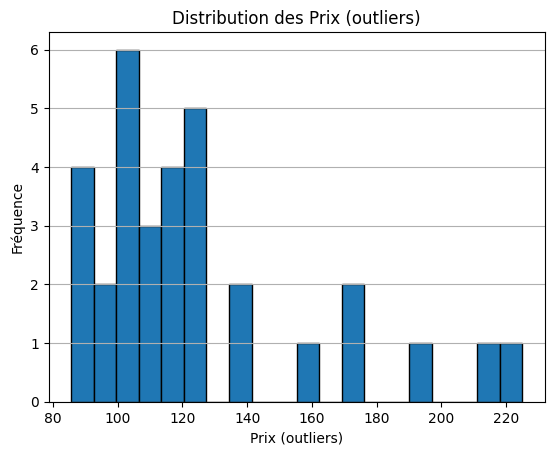

In [46]:
# Distribution des prix sur les données aberrantes
plt.hist(outliers_iqr["price"], bins=20, edgecolor="black")
plt.xlabel("Prix (outliers)")
plt.ylabel("Fréquence")
plt.title("Distribution des Prix (outliers)")
plt.grid(axis="y")
plt.show()

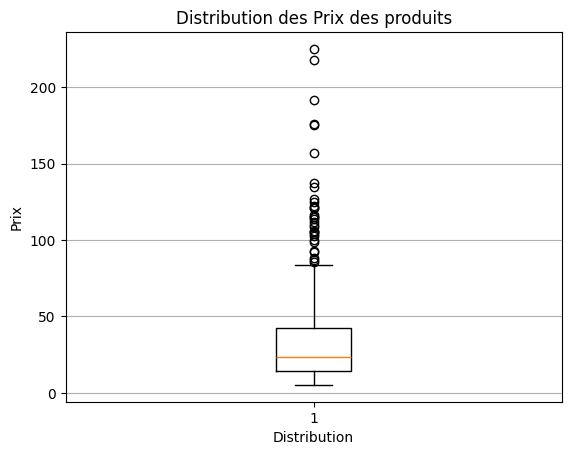

In [47]:
#Boxplot de tout les prix du dataframe final
plt.boxplot(erp_web_liaison['price'])
plt.xlabel("Distribution")
plt.ylabel("Prix")
plt.title("Distribution des Prix des produits")
plt.grid(axis="y")
plt.show()

**Tous les points au dessus de la limite (84,35€) sont de possible outliers**

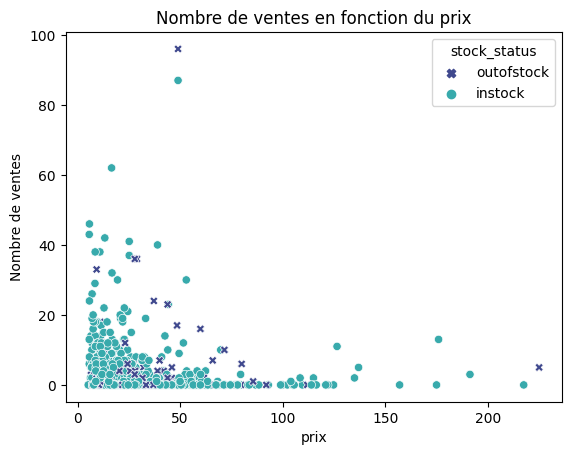

In [48]:
#Representation graphique en nuage de points:
sns.scatterplot(data=erp_web_liaison,
                x="price",
                y="total_sales",
                hue="stock_status",
                style="stock_status",
                palette="mako",
                hue_order=("outofstock","instock"))
plt.xlabel("prix")
plt.ylabel("Nombre de ventes")
plt.title("Nombre de ventes en fonction du prix")
plt.show()

In [49]:
# Ligne ou le prix est le plus élevé
max_price = erp_web_liaison["price"].max()
max_price_row = erp_web_liaison.loc[erp_web_liaison["price"] == max_price]
max_price_row

,product_id,onsale_web,price,stock_quantity,stock_status,sku,total_sales,post_date,post_title,ca_produit
669,4352,1,225.0,0,outofstock,15940,5.0,2018-03-02 10:30:04,Champagne Egly-Ouriet Grand Cru Millésimé 2008,1125.0


Nous sommes à court de la bouteille la plus chère - 225€ pour le Champagne Egly-Ouriet Grand Cru Millésimé 2008

In [50]:
# Ligne ou le nombre de vente est le plus élevé
max_sales = erp_web_liaison["total_sales"].max()
max_sales_row = erp_web_liaison.loc[erp_web_liaison["total_sales"] == max_sales]
max_sales_row

,product_id,onsale_web,price,stock_quantity,stock_status,sku,total_sales,post_date,post_title,ca_produit
364,4334,1,49.0,0,outofstock,7818,96.0,2018-03-01 14:02:44,Champagne Gosset Grand Blanc de Blancs,4704.0


Nous sommes à court de notre bestseller - 96 ventes à 49€ pour le Champagne Gosset Grand Blanc de Blancs

<div style="background-color: RGB(0,150,250);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 8 - Conclusions</h2>
</div>

Nos recommendations :

Dans un premier temps : Identifier et corriger les erreurs de saisie des données actuelles grâce aux acteurs métiers. Cela permettra d'améliorer la fiabilité des analyses de vente et de la prise de décision.

Dans un second temps : Mettre en place un système centralisé des produits et ventes en ligne afin de gagner en simplicité de gestion et fiabilité des données comme shopify par exemple.

Dans un troisième temps : Intégrer un système d'analytics sur votre site (Google Analytics) afin d'acquérir des insights supplémentaires sur le comportement des utilisateurs en ligne (produits davantages consulter ? Villes/Pays d'achat ?...)


Les erreurs notés sur le projet: 
- Des prix négatifs 'erp' remplacer par la valeur absolu positive
- Des stocks négatifs 'erp' remplacer par 0
- Stock_status 'erp' incohérants (outofstock alors qu'il y a du stock") remplacer par le stock_status réel
- Encodage 'web' sur la colonne "post_excerpt" appliquer un html.parser
- fichier liaison - id_web remplacer par "sku" 
- fichier liaison - product_id integer remplacer par object
- 32 lignes Outliers 
- 2 sku dans 'web' qui sont à 2 chiffres -> 38 et 42 - Ils ont leurs équivalent product_id donc je les laisses 